# convert images with mask to labelme format

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import yaml
from pathlib import Path
import os
import shutil

# doanload data set

## vton_dataset

In [ ]:
!wget -O zalando-hd-resized.zip https://www.dropbox.com/scl/fi/xu08cx3fxmiwpg32yotd7/zalando-hd-resized.zip?rlkey=ks83mdv2pvmrdl2oo2bmmn69w&e=1&dl=0

--2024-05-17 17:28:37--  https://www.dropbox.com/scl/fi/xu08cx3fxmiwpg32yotd7/zalando-hd-resized.zip?rlkey=ks83mdv2pvmrdl2oo2bmmn69w
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9dd88a7c45b22cdac8fe58a2ca.dl.dropboxusercontent.com/cd/0/inline/CTFfb9W5fUvagiKBLcdb07dNZMqSC4Hnle7yBRVX2__GDnH0B77YW0uYGenk8X5SgLOApYeuYjZsnLSWID2W8mRtxxgrC5JAiIl1GMDBtneXadezz2nAR_vj0hRqnkIPYwLKSYVjKPAfqwE2dNDI4LFJ/file# [following]
--2024-05-17 17:28:37--  https://uc9dd88a7c45b22cdac8fe58a2ca.dl.dropboxusercontent.com/cd/0/inline/CTFfb9W5fUvagiKBLcdb07dNZMqSC4Hnle7yBRVX2__GDnH0B77YW0uYGenk8X5SgLOApYeuYjZsnLSWID2W8mRtxxgrC5JAiIl1GMDBtneXadezz2nAR_vj0hRqnkIPYwLKSYVjKPAfqwE2dNDI4LFJ/file
Resolving uc9dd88a7c45b22cdac8fe58a2ca.dl.dropboxusercontent.com (uc9dd88a7c45b22cdac8fe58a2ca.dl.dropboxusercontent.com)... 162.125.64

In [ ]:
! unzip zalando-hd-resized.zip -d vton_hd_dataset

Streaming output truncated to the last 5000 lines.
  inflating: vton_hd_dataset/train/openpose_json/08392_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08393_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08394_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08396_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08397_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08398_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08399_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08400_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08403_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08404_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08405_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/08407_00_keypoints.json  
  inflating: vton_hd_dataset/train/openpose_json/

# extract colors

In [ ]:
image = cv2.imread('/content/vton_hd_dataset/test/image-parse-v3/13723_00.png')

reshaped_image = image.reshape(-1, 3)

unique_colors = np.unique(reshaped_image, axis=0)

print(unique_colors)

[[  0   0   0]
 [  0   0 254]
 [  0  51  85]
 [  0  85 254]
 [ 85  85   0]
 [220 169  51]
 [254   0   0]
 [254 254   0]]


In [ ]:
masked_image = image.copy()

mask = np.all(image == [85, 85, 0], axis=-1)

masked_image[mask] = [255, 255, 255]

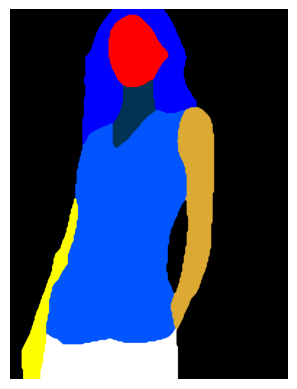

In [ ]:
# Convert the NumPy array to a PIL image
pil_image = Image.fromarray(np.uint8(masked_image))

# Display the image
plt.imshow(pil_image)
plt.axis('off')  # Hide the axis
plt.show()

colors:

- 0, 0, 254 -> hair
- 0, 51, 85 -> neck
- 0, 85, 254 -> upper body
- 85, 85, 0 -> lower body
- 220, 169, 51 -> left hand (right hand from our pov)
- 254, 0, 0 -> face
- 254, 254, 0 -> right hand (left hand from our pov)
- 0, 128, 0 -> skirt
- 0, 0, 0 -> back ground

# create polygon of specific colors

In [ ]:
def convert_mask_to_polygon(mask):
    """Converts a binary mask image into a list of polygons.

    Args:
        mask (numpy.ndarray): The input binary mask image.

    Returns:
        list: A list of polygons, where each polygon is represented as a numpy array of vertices.
    """
    # Convert the mask to binary
    _, binary = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and approximate to polygons
    polygons = []
    for contour in contours:
        # Approximate the contour to a polygon with epsilon = 0.001 * perimeter
        epsilon = 0.001 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon.reshape(polygon.shape[0], polygon.shape[2]))

    return polygons

In [ ]:
masked_image = np.zeros(image.shape[:2], dtype=np.uint8)

mask = np.all(image == [85, 85, 0], axis=-1)

masked_image[mask] = 255

polygon = convert_mask_to_polygon(masked_image)[0]

In [ ]:
polygon

array([[ 460,  887],
       [ 456,  885],
       [ 451,  894],
       [ 443,  903],
       [ 428,  912],
       [ 423,  912],
       [ 416,  916],
       [ 407,  916],
       [ 400,  920],
       [ 383,  920],
       [ 376,  924],
       [ 315,  924],
       [ 308,  920],
       [ 299,  920],
       [ 280,  912],
       [ 271,  912],
       [ 264,  916],
       [ 247,  916],
       [ 240,  920],
       [ 227,  920],
       [ 220,  924],
       [ 207,  924],
       [ 200,  928],
       [ 147,  928],
       [ 130,  913],
       [ 123,  912],
       [ 113,  907],
       [ 106,  901],
       [ 101,  900],
       [ 100,  924],
       [  96,  931],
       [  96,  948],
       [  92,  955],
       [  92,  976],
       [  88,  983],
       [  88,  992],
       [  84,  999],
       [  84, 1023],
       [ 463, 1023],
       [ 463,  935],
       [ 459,  928]], dtype=int32)

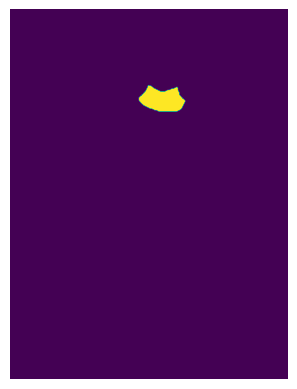

In [ ]:
# Define the polygon points
polygon_points = polygon.reshape((-1, 1, 2))  # Reshape for cv2.fillPoly

# Create a blank black image (all zeros)
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Fill the polygon with white color (255)
cv2.fillPoly(mask, [polygon_points], 255)

# Convert the NumPy array to a PIL image
pil_image = Image.fromarray(np.uint8(mask))

# Display the image
plt.imshow(pil_image)
plt.axis('off')  # Hide the axis
plt.show()

# convert to yolo v8 format

## create yamle file

In [ ]:
def create_yaml_file(output_path, labels_list):
    '''create yaml file for dataset'''
    data = {
        'train': f'{output_path}/train/images',
        'test': f'{output_path}/test/images',
        'val': f'{output_path}/valid/images',
        'nc': len(labels_list),
        'names': labels_list
        }
    # Write the data to the YAML file
    with open(f'{output_path}/data.yaml', 'w') as yaml_file:
        yaml.dump(data, yaml_file)

## create label text files

In [ ]:
def convert_polygons_to_labels(image_hight, image_width, polygons_list, output_path):
    with open(output_path, 'w') as label_file:
        for index, polygon in enumerate(polygons_list):
            if len(polygon):
                label_file.write(f'{index} ')
                polygon_normalize = map(lambda point: [point[0]/image_width, point[1]/image_hight], polygon)
                for x, y in polygon_normalize:
                    label_file.write(f'{x} {y} ')
                label_file.write('\n')

In [ ]:
convert_polygons_to_labels(image.shape[0], image.shape[1], [polygon], 'label.txt')

# create pipe line

create train and validation dataset for train yolov8

create yaml file

In [ ]:
def yolo_dataset(image_pars_path, output_path, limit):
    # create directories
    if not os.path.exists(os.path.join(output_path, 'labels')):
        os.makedirs(os.path.join(output_path, 'labels'))
    if not os.path.exists(os.path.join(output_path, 'images')):
        os.makedirs(os.path.join(output_path, 'images'))

    # Get the list of all files
    image_pars_files = [f for f in image_pars_path.iterdir() if f.is_file()]

    # create polygons
    color_targets = [[0, 0, 254], [0, 51, 85], [0, 85, 254], [85, 85, 0], [220, 169, 51], [254, 0, 0], [254, 254, 0], [0, 128, 0]]
    for count, image_path in enumerate(image_pars_files):
        if count >= limit:
            break
        image = cv2.imread(str(image_path))
        polygons_list = []
        for color in color_targets:
            # create mask for specific color
            masked_image = np.zeros(image.shape[:2], dtype=np.uint8)
            masked_image[np.all(image == color, axis=-1)] = 255
            # create the polygon
            polygon = convert_mask_to_polygon(masked_image)
            if polygon:
                polygons_list.append(polygon[0])
            else:
                polygons_list.append([])
        # create labels
        convert_polygons_to_labels(image.shape[0], image.shape[1], polygons_list, os.path.join(output_path, 'labels', image_path.stem + '.txt'))
        # copy the image to directory
        shutil.copy(os.path.join(image_path.parent.parent, 'image', image_path.stem + '.jpg'), os.path.join(output_path, 'images'))

In [ ]:
! rm -rf /content/yolo_dataset

In [ ]:
# Specify the directory
train_directory_image_pars = Path('/content/vton_hd_dataset/train/image-parse-v3')
valid_directory_image_pars = Path('/content/vton_hd_dataset/test/image-parse-v3')

In [ ]:
yolo_dataset(train_directory_image_pars, 'yolo_dataset/train', 1000)

In [ ]:
yolo_dataset(valid_directory_image_pars, 'yolo_dataset/valid', 200)

In [ ]:
image_pars_path = Path('/content/yolo_dataset/valid/images')
image_pars_files = [f for f in image_pars_path.iterdir() if f.is_file()]
print(len(image_pars_files))

200


## create yaml file

In [ ]:
create_yaml_file('/content/yolo_dataset', ['hair', 'neck', 'upper_body', 'lower_body', 'left_hand', 'face', 'right_hand', 'skirt'])

# zip the dataset and upload to google drive

In [ ]:
! zip -r yolo_image_pars_dataset.zip /content/yolo_dataset

updating: content/yolo_dataset/ (stored 0%)
updating: content/yolo_dataset/data.yaml (deflated 45%)
updating: content/yolo_dataset/valid/ (stored 0%)
updating: content/yolo_dataset/valid/images/ (stored 0%)
updating: content/yolo_dataset/valid/images/12972_00.jpg (deflated 4%)
updating: content/yolo_dataset/valid/images/03677_00.jpg (deflated 1%)
updating: content/yolo_dataset/valid/images/02595_00.jpg (deflated 1%)
updating: content/yolo_dataset/valid/images/10687_00.jpg (deflated 3%)
updating: content/yolo_dataset/valid/images/09019_00.jpg (deflated 0%)
updating: content/yolo_dataset/valid/images/03361_00.jpg (deflated 2%)
updating: content/yolo_dataset/valid/images/05374_00.jpg (deflated 1%)
updating: content/yolo_dataset/valid/images/01528_00.jpg (deflated 1%)
updating: content/yolo_dataset/valid/images/02914_00.jpg (deflated 2%)
updating: content/yolo_dataset/valid/images/13071_00.jpg (deflated 3%)
updating: content/yolo_dataset/valid/images/13758_00.jpg (deflated 3%)
updating: co

In [ ]:
# connect to google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp /content/yolo_image_pars_dataset.zip /content/drive/MyDrive/ai_projects/vton/image_parsing

In [ ]:
! cp /content/yolo_dataset/valid/labels/13723_00.txt .
! cp /content/yolo_dataset/valid/images/13723_00.jpg .